In [275]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

  Activating environment at `~/Dropbox/Mac/Documents/School/Graduate School/CMU/2021-2022/Spring 2022/745-Optimal Control and Reinforcement Learning/Final Project/Code/16745-threebody/src/Project.toml`


In [276]:
using LinearAlgebra
using Plots
using ForwardDiff
using RobotZoo
using RobotDynamics
using Ipopt
using MathOptInterface
using StaticArrays
using SparseArrays
using MATLAB 
using CSV
using DataFrames
# Pkg.add("Statistics")
using Statistics 
include("Dimensions.jl")
include("Plotting.jl")
include("Calculate_LPoints.jl")
include("Non_lin_exp.jl")
include("CR3BP_Dynamics.jl")
include("sparseblocks.jl")
include("MOI.jl")
include("NLP.jl")
const MOI = MathOptInterface;

# Final Project: Non-Linear Trajectory Optimization of Halo Orbits using DIRCOL

An understanding of halo orbits and how to model them, as well as how to control a spacecraft to maintain such an orbit, is essential for successful traversal through the solar system and beyond. This paper demonstrates methods for how all of these goals can be achieved in a robust and computationally efficient manner. Specifically, direct collocation with the use of the IPOPT solver is shown to be an effective method of generating halo orbits, while a time-varying LQR controller can be used on a satellite to track these orbits.

## The Dynamics
Our system is modeled as the motion of a third body under the influence of the gravitational fields created by two primary bodies.
You're encouraged to look at the code in [src/CR3BP_Dynamics.jl]We got the dynamics function from (https://github.com/jared711/ThreeBodyProblem.jl/blob/master/src/dynamics.jl)

The state and control vectors are ordered as follows:

$$ x = \begin{bmatrix} 
    p_x \\ p_y \\ p_z \\ V_x \\ V_y \\ V_z 
\end{bmatrix}
$$

Note: $p$ is the position of the third body and $V$ is the velocity of the body. Because we want this problem to be a Free/Minimun time problem we are treating the timestep $h$ as an input in the discretized dynamics. That's the reason in the code below we are setting $N_u = 1$

In [277]:
#Refer to Dimensions.jl for the functions 
# Define states and controls
Nx = 6     # Number of states
Nu = 1     # Number of controls

# Specify System, Lagrange point, and if we want dimensional or dimensionless system
LagrangePoint = 1
Dimensionless = true
System = "Sun-Earth"

# Specify plotting parameters
MatlabPlotting = true#false

# Calculate Lagrange points for specified system
L1, L2, L3, L4, L5 = get_LPoints(System)

# Get period of orbit, define number of knot points and generate thist vector
Tfinal, Tfinal_days = get_Period(LagrangePoint, System)
Nt = 50              # Number of knot points --> generates number of time steps-52
h = Tfinal/(Nt - 1)  # Timestep

thist = Array(range(0, Tfinal, step = h)); 
n_nlp = (Nx + Nu)*Nt # Number of decision variables-350
m_nlp = Nx*(Nt)  # 306
u_idx = [(Nx + Nu)*(i - 1) .+ (Nx + 1:Nx + Nu) for i = 1:Nt];
x_idx = [(Nx + Nu)*(i - 1) .+ (1:Nx) for i = 1:Nt];

println("Timestep h: ", h)
println("Period (dimensionless): ", Tfinal)
println("Period (in days): ", Tfinal_days)


Timestep h: 0.06145759910513664
Period (dimensionless): 3.0114223561516953
Period (in days): 174.93820510742933


## Reference Trajectory
To create a decently accurate reference trajectory we used the Non Linear 3rd Order expansion provided by KoLoMaRo(Textbook). Please refer to: Non_lin_exp.jl for the functions 

In [278]:
# Generate Reference Trajectory 
Xref,Uref = get_reference()
print("Step size in x: ", Xref[2][1] - Xref[1][1])


Step size in x: 1.133855799528849e-5

In [279]:
xRef = zeros(Nt)
yRef = zeros(Nt)
zRef = zeros(Nt)

for k = 1:Nt
    xRef[k] = Xref[k][1]
    yRef[k] = Xref[k][2]
    zRef[k] = Xref[k][3]
end

# Plots.plot(xRef,yRef)

## Optimal Control Problem Set Up: 
$$
\underset{\Delta{X},\Delta{U}}{\text{minimize }}
\sum_{k=1}^{N}\frac{1}{2}\Delta{X}'Q\Delta{X}+\frac{1}{2}\Delta{U}'R\Delta{U} \\

\text{Where: } \Delta{X} = X_k-X_{ref},\Delta{U} =U_k-U_{ref} \\ 

\text{subject to:} f(x_k) + \frac{3}{2h}(x_k-x_{k+1})- \frac{1}{4}(f(x_k)+f(x_{k+1})) = 0
% $x_{init}$-$x_{goal}$ = 0
$$

In [280]:
# Cost weights
Q = Diagonal([0.95*ones(3); 0.95*ones(3)]);
R = 0.001;

In [281]:
function stage_cost(x,u,Xref,Uref)
    return 0.5*((x.-Xref)'*Q*(x.-Xref)) + 0.5*(u.-Uref)'*R*(u.-Uref)
end

stage_cost (generic function with 1 method)

In [282]:
function cost(ztraj)
    z = reshape(ztraj,Nx+Nu,Nt)
    J = 0.0
    for k = 1:Nt
        J += stage_cost(z[1:Nx,k],z[(Nx+1):(Nx+Nu),k],Xref[k],Uref[k])
    end
    return J
end

cost (generic function with 1 method)

In [283]:
#Please refer to MOI.jl and NLP.jl for the setup functions of the NLP as well as CR3BPDynamics.jl for the Dircol Dynamics
struct ProblemMOI <: MOI.AbstractNLPEvaluator
    n_nlp::Int
    m_nlp::Int
    idx_ineq
    obj_grad::Bool
    con_jac::Bool
    sparsity_jac
    sparsity_hess
    primal_bounds
    constraint_bounds
    hessian_lagrangian::Bool
    blocks::BlockViews
end 
function ProblemMOI(n_nlp,m_nlp;
    idx_ineq=(1:0),
    obj_grad=true,
    con_jac=true,
    sparsity_jac=sparsity_jacobian(n_nlp,m_nlp),
    sparsity_hess=sparsity_hessian(n_nlp,m_nlp),
    primal_bounds=primal_bounds(n_nlp),
    constraint_bounds=constraint_bounds(m_nlp,idx_ineq=idx_ineq),
    hessian_lagrangian=false,
    blocks = BlockViews(m_nlp,n_nlp))
    ProblemMOI(n_nlp,m_nlp,
            idx_ineq,
            obj_grad,
            con_jac,
            sparsity_jac,
            sparsity_hess,
            primal_bounds,
            constraint_bounds,
            hessian_lagrangian,
            blocks)
end

ProblemMOI

In [284]:
#Guess
z0 = zeros((Nx+Nu)*(Nt))
z0[x_idx[1]] = Xref[1]
for k=1:Nt
    z0[x_idx[k]] = Xref[k]
    z0[u_idx[k]] .= Uref[k]
end

In [285]:
prob = ProblemMOI(n_nlp,m_nlp)
z_sol = solve(z0,prob) # solve

This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3834
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      350
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       50
                     variables with only upper bounds:        0
Total number of equality constraints.................:      300
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

350-element Vector{Float64}:
  0.9888369436438311
  2.549694276766585e-8
  0.0008017460299848887
  2.3507891296633945e-8
  0.008937101884826968
 -7.333161998846873e-9
  0.05652929546292377
  0.9888500870324154
  0.0005041446573023428
  0.0007976433943476095
  0.00046413935065954174
  0.0088793532503329
 -0.0001450281774794708
  ⋮
  0.000797643883114492
 -0.00046411188020810385
  0.008879360121536579
  0.00014501955248088743
  0.05653163059761482
  0.9888369436438311
  2.5496942767665015e-8
  0.0008017460299848887
  2.3507891296634025e-8
  0.008937101884826968
 -7.3331619988467305e-9
  0.061457977086097515

In [286]:
ztraj = reshape(z_sol,Nx+Nu,Nt);
xtraj = ztraj[1:Nx,:];#6 x 50
utraj = ztraj[(Nx+1):(Nx+Nu),:]; # 1 x 91
xonly = xtraj[1,:];
yonly = xtraj[2,:];
zonly = xtraj[3,:];


In [287]:
#Refer to Plotting.jl for the functions used 
# Plot reference vs IPOPT orbit
if !MatlabPlotting
    p = Plots.plot(xRef, yRef, label = "Reference")
    Plots.plot!(p, xtraj[1,:], xtraj[2,:], label = "IPOPT")
else
    Ref_IPOPT_3D_Plot()
end

In [288]:
# Plot X, Y, and Z individually
if !MatlabPlotting
    reduceBy = findmax(xtraj[1,:])
    p = Plots.plot(thist, xtraj[1,:] .- reduceBy[1], label = "X")
    Plots.plot!(p, thist, xtraj[2,:], label = "Y")
    Plots.plot!(p, thist, xtraj[3,:], label = "Z")
else
    Ref_IPOPT_XYZ_Plot()
end


In [289]:
# Look at period generated by IPOPT
u = 0
for i=1:Nt
    u += utraj[1, i]
end
Period_IPOPT = (u/(2*pi))*3.1536e7/(24*60*60)
@show Period_IPOPT

# Show plot of timesteps
uonly = utraj[1,:]
if !MatlabPlotting
    mx, mi = findmax(utraj[1,:])
    # Plots.plot(thist, uonly, label = "Timesteps")
    Plots.scatter(thist, uonly, label = "Timesteps")
else
    IPOPT_Timesteps_Plot()
end

Period_IPOPT = 181.31199742614325


In [290]:
xTraj = zeros(Nt)
yTraj = zeros(Nt)
ztraj = zeros(Nt)

for k = 1:Nt
    xTraj[k] = xtraj[1,k]
    yTraj[k] = xtraj[2,k]
    ztraj[k] = xtraj[3,k]
end


In [291]:
#Refer to Families.jl to dig into the functions
### Implement Continuation of Libration point Orbits
include("Families.jl")
numIters = 200
scaleValue = 0.05
Up = true
x_fam = Generating_Orbit_Families(z0, numIters, scaleValue, Up)

This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3834
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      350
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       50
                     variables with only upper bounds:        0
Total number of equality constraints.................:      300
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

6×50×200 Array{Float64, 3}:
[:, :, 1] =
  0.988837      0.98885       0.98889      …   0.98885       0.988837
  2.54969e-8    0.000504145   0.00100856      -0.000504115   2.54969e-8
  0.000801746   0.000797643   0.000785149      0.000797644   0.000801746
  2.35079e-8    0.000464139   0.000924285     -0.000464112   2.35079e-8
  0.0089371     0.00887935    0.00870382       0.00887936    0.0089371
 -7.33316e-9   -0.000145028  -0.000290641  …   0.00014502   -7.33316e-9

[:, :, 2] =
  0.988837      0.988851      0.988892     …   0.988851      0.988837
  4.14953e-8    0.000511701   0.00102277      -0.000511621   4.14953e-8
  0.000816578   0.000812277   0.000799205      0.000812279   0.000816578
  3.8255e-8     0.000471007   0.00093701      -0.000470934   3.8255e-8
  0.00894091    0.00888145    0.00870108       0.00888147    0.00894091
 -1.21421e-8   -0.000149841  -0.000300031  …   0.000149817  -1.21421e-8

[:, :, 3] =
  0.988837      0.988851      0.988893     …   0.988851      0.988837
 -7.

In [292]:
L = size(x_fam)[3]
if MatlabPlotting
    Family_Orbits_Plot()
end

In [293]:
xtraj = [xtraj[:,i] for i in 1:size(xtraj,2)];
utraj = [utraj[:,i] for i in 1:size(utraj,2)];

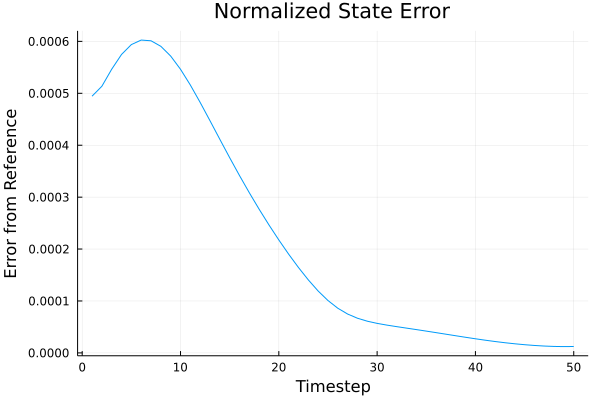

In [294]:
#The dynamics functions used for the controller are in at the bottom of CR3BPDynamics.jl 
#make sure you use dimensionless
Nu = 3
#Establish Variables
Q = Diagonal([10,10,10,10,10,10])
R = Diagonal([1,1,1]) #we want to conserve fuel
Qf = Diagonal([100,100,100,100,100,100]) #this can be the same as Q since its a periodic orbit so the end isnt special
K = [zeros(Nu,Nx)*NaN for k = 1:Nt-1]
P = [zeros(Nx,Nx)*NaN for k = 1:Nt]

#Initialize jacobians
A = [zeros(Nx,Nx) for k = 1:Nt]
B = [zeros(Nu,Nu) for k = 1:Nt-1]

#Initialize control
U = [zeros(Nu) for k = 1:Nt-1] #under ideal circumstances, no controls need to be expended. (does this mean B will stay zeros?)

###############################
#ACTUALLY RUN THE TVLQR
#Everything is done in non-dimensional coordinates
#xtraj is our halo orbit trajectory we are trying to stick to
#Xsat is the satellite
linearize!(A,B,xtraj, U)

calc_gains!(xtraj, A, B, P, K, Qf, Q)

Xsat = [zeros(Nx) for k = 1:Nt] 

#You need to add some perturbation to this or the controller should just do nothing
#(in practice, it just gives very very small control inputs since the controller is not perfect)
#The below is our perturbation. The entire state is multiplied by a scalar which affects both the starting 
#position and velocity. The controller then recovers from this. 1.0001 was chosen 
Xsat[1] = copy(xtraj[1])*1.0005 
# Xsat[1] = Xsat[1] + [.0001, .0001, .0001, 0, 0, 0]

for k = 1:Nt-1
    U[k] = U[k] - K[k]*(Xsat[k]-xtraj[k]) #in hw this was often the get_control function
    Xsat[k+1] = rk4WithU(CR3BPdynamicsWithUforA, Xsat[k], U[k], utraj[k])  #discrete_dynamics(RK4, model, X[k], U[k], times[k], dt) 
end

# ###############################



#plot error
sse = zeros(length(Xsat))
for k = 1:Nt
    sse[k] = norm(Xsat[k]-xtraj[k])
end
t = Array(range(1, Nt, step = 1));

xtrajX = zeros(length(xtraj))
xtrajY = zeros(length(xtraj))
xtrajZ = zeros(length(xtraj))

XsatX = zeros(length(xtraj))
XsatY = zeros(length(xtraj))
XsatZ = zeros(length(xtraj))

for k in 1:Nt
    xtrajX[k] = xtraj[k][1]
    xtrajY[k] = xtraj[k][2]
    xtrajZ[k] = xtraj[k][3]
    
    XsatX[k] = Xsat[k][1]
    XsatY[k] = Xsat[k][2]
    XsatZ[k] = Xsat[k][3]
end


Ux = zeros(length(U))
Uy = zeros(length(U))
Uz = zeros(length(U))
for k in 1:Nt-1
    Ux[k] = U[k][1]
    Uy[k] = U[k][2]
    Uz[k] = U[k][3]
end

#plots the SSE of the satellite over time
plot(t, sse, title = "Normalized State Error", label = "", xaxis = "Timestep", yaxis = "Error from Reference")

# print(sse[49])
# # plot(t[1:end-1], Uz)
# # plot(xtraj, Xsat)
# # print(U)

# ##############################################



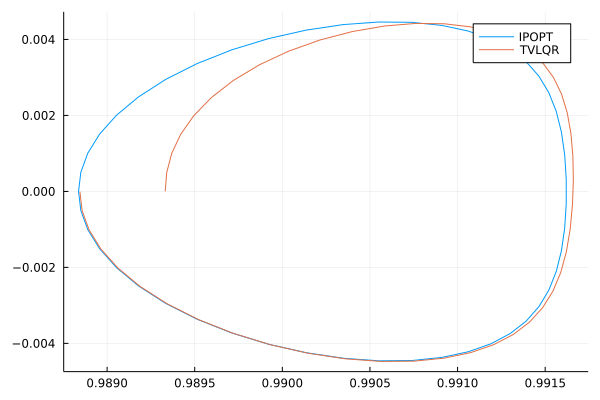

In [295]:
#2d view of perturbed TVLQR vs target halo orbit from IPOPT
p = Plots.plot(xtrajX, xtrajY, label = "IPOPT")
Plots.plot!(p, XsatX, XsatY, label = "TVLQR")

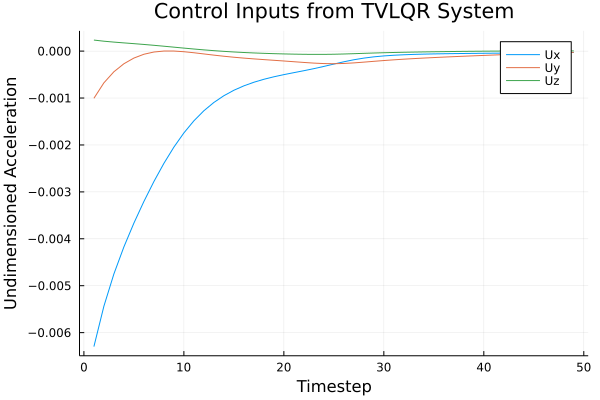

In [296]:
p = Plots.plot(t[1:end-1], Ux, label = "Ux", title = "Control Inputs from TVLQR System", xaxis = "Timestep", yaxis = "Undimensioned Acceleration")
Plots.plot!(p, t[1:end-1], Uy, label = "Uy")
Plots.plot!(p, t[1:end-1], Uz, label = "Uz")

In [297]:
# Plot LQR vs. Reference
if !MatlabPlotting
    p = Plots.plot3d(XsatX,XsatY,XsatZ, label = "Xsat")
    Plots.plot3d!(p, xtrajX,xtrajY,xtrajZ, label = "xtraj")
    # plot3d(XsatX,XsatY,XsatZ)
else
    TVQLR_Plot()
end